In [2]:
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
import torch
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib as plt
from PIL import Image
sys.path.append('../src')
from utils import *
from matplotlib.lines import Line2D
import matplotlib as mpl
import math
import matplotlib.image as mpimg
import scipy.stats as stats
import scipy as sp
from scipy.stats import pearsonr,binom,linregress
from ast import literal_eval
import json

In [68]:
# Used in CCN
# folder   = "SCS UC 10:250:5 0.6 Exp3 AE Fixed copy"
# log_path = "/export/raid1/home/kneel027/Second-Sight/logs/" + folder + "/statistics_df_60.csv"


# Second Sight
subject = 1
folder = "dataframes"
# experiment = "Brain Diffuser regen"
# experiment = "Cortical Convolutions"
# experiment = "Mind Diffuser"
# experiment = "Tagaki"
experiment = "Final Run: SCS UC LD 6:100:4 Dual Guided clip_iter"
# experiment = "iter_5"
directory_path = "/export/raid1/home/ojeda040/Second-Sight-Archive/reconstructions/subject" + str(subject) + "/" + folder + "/statistics_df_" + experiment + "_only_brain_correlation_897.csv"

# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", None)
# pd.set_option('display.max_seq_items', None)
df = pd.read_csv(directory_path)
df.head(100)

#   0 --> Ground Truth
#   1 --> VDVAE Distribution        (Decoded Distribution)
#   2 --> Clip Distrubituon         (Decoded CLIP Only)
#   3 --> Clip Distrubituon + VDVAE (Decoded CLIP + VDVAE)
#   4 --> iter_0
#   5 --> iter_1
#   6 --> iter_2
#   7 --> iter_3
#   8 --> iter_4
#   9 --> iter_5
#  10 --> Search Reconstruction


Unnamed: 0  ID  Sample Count  Batch Number Search Reconstruction   
0            0  20           0.0           NaN                   NaN  \
1            1  20           1.0           NaN                   NaN   
2            2  20           2.0           NaN                   NaN   
3            3  20           3.0           NaN                   NaN   
4            4  20           4.0           NaN                   NaN   
..         ...  ..           ...           ...                   ...   
95          95  21           2.0           NaN                   NaN   
96          96  21           3.0           NaN                   NaN   
97          97  21           4.0           NaN                   NaN   
98          98  21           5.0           NaN                   NaN   
99          99  21           6.0           NaN                   NaN   

    Sample Indicator  Strength  Brain Correlation V1  Brain Correlation V2   
0                  1  0.918611              0.149382              0.229241  \
1                  1  0.908889              0.147515              0.167405   
2                  1  0.882500              0.169191              0.110722   
3                  1  0.831111              0.176302              0.178764   
4                  1  0.746389              0.189786              0.183530   
..               ...       ...                   ...                   ...   
95                 3  0.882500              0.342362              0.303776   
96                 3  0.831111              0.228850              0.287911   
97                 3  0.746389              0.230543              0.282433   
98                 3  0.620000              0.236455              0.299094   
99                 3  0.443611              0.212515              0.325639   

    Brain Correlation V3  ...  SSIM  Pixel Correlation  CLIP Cosine   
0               0.329448  ...   NaN                NaN          NaN  \
1               0.236061  ...   NaN                NaN          NaN   
2               0.078040  ...   NaN                NaN          NaN   
3               0.232333  ...   NaN                NaN          NaN   
4               0.225880  ...   NaN                NaN          NaN   
..                   ...  ...   ...                ...          ...   
95              0.316346  ...   NaN                NaN          NaN   
96              0.248150  ...   NaN                NaN          NaN   
97              0.298181  ...   NaN                NaN          NaN   
98              0.309843  ...   NaN                NaN          NaN   
99              0.263697  ...   NaN                NaN          NaN   

    CLIP Two-way  AlexNet 2  AlexNet 5  AlexNet 7  Inception V3  EffNet-B   
0            NaN        NaN        NaN        NaN           NaN       NaN  \
1            NaN        NaN        NaN        NaN           NaN       NaN   
2            NaN        NaN        NaN        NaN           NaN       NaN   
3            NaN        NaN        NaN        NaN           NaN       NaN   
4            NaN        NaN        NaN        NaN           NaN       NaN   
..           ...        ...        ...        ...           ...       ...   
95           NaN        NaN        NaN        NaN           NaN       NaN   
96           NaN        NaN        NaN        NaN           NaN       NaN   
97           NaN        NaN        NaN        NaN           NaN       NaN   
98           NaN        NaN        NaN        NaN           NaN       NaN   
99           NaN        NaN        NaN        NaN           NaN       NaN   

    SwAV  
0    NaN  
1    NaN  
2    NaN  
3    NaN  
4    NaN  
..   ...  
95   NaN  
96   NaN  
97   NaN  
98   NaN  
99   NaN  

[100 rows x 24 columns]

In [4]:
# Create CNN metric columns into lists (Only run if computing CNN Metrics)

def column_string_to_list(df):
    
    df_new = df
    
    for index, row in tqdm(df.iterrows(), "creating lists"):
        
        df_new.at[index, 'CLIP Two-way']    = json.loads(row['CLIP Two-way'])
        df_new.at[index, 'AlexNet 2']       = json.loads(row['AlexNet 2'])
        df_new.at[index, 'AlexNet 5']       = json.loads(row['AlexNet 5'])
        df_new.at[index, 'AlexNet 7']       = json.loads(row['AlexNet 7'])
        df_new.at[index, 'Inception V3']    = json.loads(row['Inception V3'])
        df_new.at[index, 'EffNet-B']        = json.loads(row['EffNet-B'])
        df_new.at[index, 'SwAV']            = json.loads(row['SwAV'])
        
    return df_new

new_df = column_string_to_list(df)

creating lists: 42159it [24:10, 29.06it/s]


In [21]:
# Statistical Analysis Second Sight

# Input: Dataframe containing the samples one type of image
def create_cnn_numpy_array(df):
    cnn_dict = {}
    df = df.reset_index()
    
    alexnet_2       = []
    alexnet_5       = []
    alexnet_7       = []
    clip_two_way    = []
    inception_v3    = []
    effnet_b        = []
    swav            = []
    
    for index, row in df.iterrows():
        
        alexnet_2.append(row['AlexNet 2'])
        alexnet_5.append(np.array(row['AlexNet 5']))
        alexnet_7.append(np.array(row['AlexNet 7']))
        clip_two_way.append(np.array(row['CLIP Two-way']))
        inception_v3.append(np.array(row['Inception V3']))
        effnet_b.append(np.array(row['EffNet-B']))
        swav.append(np.array(row['SwAV']))
    
    cnn_dict['AlexNet 2']      = np.concatenate([alexnet_2])
    cnn_dict['AlexNet 5']      = np.concatenate([alexnet_5])
    cnn_dict['AlexNet 7']      = np.concatenate([alexnet_7])
    cnn_dict['CLIP Two-way']   = np.concatenate([clip_two_way])
    cnn_dict['Inception V3']   = np.concatenate([inception_v3])
    cnn_dict['EffNet-B']       = np.concatenate([effnet_b])
    cnn_dict['SwAV']           = np.concatenate([swav])
    
    return cnn_dict

def pairwise_corr_all(ground_truth, predictions):
    r = np.corrcoef(ground_truth, predictions)      #cosine_similarity(ground_truth, predictions)#
    r = r[:len(ground_truth), len(ground_truth):]   # rows: groundtruth, columns: predicitons
    
    # congruent pairs are on diagonal
    congruents = np.diag(r)
    
    # for each column (predicition) we should count the number of rows (groundtruth) 
    # that the value is lower than the congruent (e.g. success).
    success = r < congruents
    success_cnt = np.sum(success, 0)
    
    # note: diagonal of 'success' is always zero so we can discard it. That's why we divide by len-1
    perf = np.mean(success_cnt) / (len(ground_truth)-1)
    p = 1 - binom.cdf(perf*len(ground_truth)*(len(ground_truth)-1), len(ground_truth)*(len(ground_truth)-1), 0.5)
    
    return perf, p

def compute_cnn_metrics(cnn_metrics_ground_truth, cnn_metrics_reconstructions):
    
    distance_fn = sp.spatial.distance.correlation
    pairwise_corrs = []
    cnn_metrics = {}
    
    for net_name, predictions_np in cnn_metrics_reconstructions.items():
        
        gt_feat = cnn_metrics_ground_truth[net_name]
        
        eval_feat = predictions_np
        num_test = predictions_np.shape[0]
        
        if net_name == 'EffNet-B' or net_name == 'SwAV':
            cnn_metrics[net_name] = np.array([distance_fn(gt_feat[i],eval_feat[i]) for i in range(num_test)]).mean()
            
        else:
            cnn_metrics[net_name] = pairwise_corr_all(gt_feat[:num_test],eval_feat[:num_test])[0]
            
    return cnn_metrics 

df_final_samples    = new_df.loc[(new_df['Search Reconstruction'] == True)]
df_ground_truth     = new_df.loc[(new_df['Sample Indicator'] == 0)]
df_final_samples_0  = df_final_samples.loc[(df_final_samples['Sample Count'] == 0)]
df_final_samples_1  = df_final_samples.loc[(df_final_samples['Sample Count'] == 1)]
df_final_samples_2  = df_final_samples.loc[(df_final_samples['Sample Count'] == 2)]
df_final_samples_3  = df_final_samples.loc[(df_final_samples['Sample Count'] == 3)]
df_final_samples_4  = df_final_samples.loc[(df_final_samples['Sample Count'] == 4)]


cnn_metrics_0 = compute_cnn_metrics(create_cnn_numpy_array(df_ground_truth), create_cnn_numpy_array(df_final_samples_0))
cnn_metrics_1 = compute_cnn_metrics(create_cnn_numpy_array(df_ground_truth), create_cnn_numpy_array(df_final_samples_1))
cnn_metrics_2 = compute_cnn_metrics(create_cnn_numpy_array(df_ground_truth), create_cnn_numpy_array(df_final_samples_2))
cnn_metrics_3 = compute_cnn_metrics(create_cnn_numpy_array(df_ground_truth), create_cnn_numpy_array(df_final_samples_3))
cnn_metrics_4 = compute_cnn_metrics(create_cnn_numpy_array(df_ground_truth), create_cnn_numpy_array(df_final_samples_4))

print("------------------------------------------------ SSIM -----------------------------------------------------------------")

print("SSIM: ", df_final_samples['SSIM'].mean())

print("Confidence Interval SSIM: ", ((df_final_samples['SSIM'].std() * 1.96) / math.sqrt(len(df_final_samples.index))))

print("------------------------------------------------ Pixel Correlation -----------------------------------------------------------------")

print("Pixel Correlation: ", df_final_samples['Pixel Correlation'].mean())

print("Confidence Interval Pixel Correlation: ", ((df_final_samples['Pixel Correlation'].std() * 1.96) / math.sqrt(len(df_final_samples.index))))

print("------------------------------------------------ CLIP Cosine -----------------------------------------------------------------")

print("CLIP Cosine: ", df_final_samples['CLIP Cosine'].mean())

print("Confidence Interval CLIP Cosine: ", ((df_final_samples['CLIP Cosine'].std() * 1.96) / math.sqrt(len(df_final_samples.index))))

print("------------------------------------------------ CLIP Two-way -----------------------------------------------------------------")

print("CLIP Two-way: ", ((cnn_metrics_0['CLIP Two-way'] + cnn_metrics_1['CLIP Two-way'] + cnn_metrics_2['CLIP Two-way'] + cnn_metrics_3['CLIP Two-way'] + cnn_metrics_4['CLIP Two-way']) / 5))

print("------------------------------------------------ AlexNet 2 -----------------------------------------------------------------")

print("AlexNet 2: ", ((cnn_metrics_0['AlexNet 2'] + cnn_metrics_1['AlexNet 2'] + cnn_metrics_2['AlexNet 2'] + cnn_metrics_3['AlexNet 2'] + cnn_metrics_4['AlexNet 2']) / 5))

print("------------------------------------------------ AlexNet 5 -----------------------------------------------------------------")

print("AlexNet 5: ", ((cnn_metrics_0['AlexNet 5'] + cnn_metrics_1['AlexNet 5'] + cnn_metrics_2['AlexNet 5'] + cnn_metrics_3['AlexNet 5'] + cnn_metrics_4['AlexNet 5']) / 5))

print("------------------------------------------------ AlexNet 7 -----------------------------------------------------------------")

print("AlexNet 7: ", ((cnn_metrics_0['AlexNet 7'] + cnn_metrics_1['AlexNet 7'] + cnn_metrics_2['AlexNet 7'] + cnn_metrics_3['AlexNet 7'] + cnn_metrics_4['AlexNet 7']) / 5))

print("------------------------------------------------ Inception V3 -----------------------------------------------------------------")

print("Inception V3: ", ((cnn_metrics_0['Inception V3'] + cnn_metrics_1['Inception V3'] + cnn_metrics_2['Inception V3'] + cnn_metrics_3['Inception V3'] + cnn_metrics_4['Inception V3']) / 5))

print("------------------------------------------------ EffNet-B -----------------------------------------------------------------")

print("EffNet-B: ", ((cnn_metrics_0['EffNet-B'] + cnn_metrics_1['EffNet-B'] + cnn_metrics_2['EffNet-B'] + cnn_metrics_3['EffNet-B'] + cnn_metrics_4['EffNet-B']) / 5))

print("------------------------------------------------ SwAV -----------------------------------------------------------------")

print("SwAV: ", ((cnn_metrics_0['SwAV'] + cnn_metrics_1['SwAV'] + cnn_metrics_2['SwAV'] + cnn_metrics_3['SwAV'] + cnn_metrics_4['SwAV']) / 5))

print(cnn_metrics_0['Inception V3'])

------------------------------------------------ SSIM -----------------------------------------------------------------
SSIM:  0.28805564771959863
Confidence Interval SSIM:  0.00453115871984924
------------------------------------------------ Pixel Correlation -----------------------------------------------------------------
Pixel Correlation:  0.18516724942251953
Confidence Interval Pixel Correlation:  0.005675563279077434
------------------------------------------------ CLIP Cosine -----------------------------------------------------------------
CLIP Cosine:  0.6642020871800892
Confidence Interval CLIP Cosine:  0.003460082949051444
------------------------------------------------ CLIP Two-way -----------------------------------------------------------------
CLIP Two-way:  0.8827530259595477
------------------------------------------------ AlexNet 2 -----------------------------------------------------------------
AlexNet 2:  0.9166385471412646
---------------------------------------

In [13]:
cnn = create_cnn_numpy_array(df_final_samples_2)
gt = create_cnn_numpy_array(df_ground_truth)


In [70]:
cnn = create_cnn_numpy_array(df_final_samples_4)
gt = create_cnn_numpy_array(df_ground_truth)

def pairwise_corr_all(ground_truth, predictions):
    r = np.corrcoef(ground_truth, predictions)      # cosine_similarity(ground_truth, predictions)
    r = r[:len(ground_truth), len(ground_truth):]   # rows: groundtruth, columns: predicitons
    
    # congruent pairs are on diagonal
    congruents = np.diag(r)
    
    # for each column (predicition) we should count the number of rows (groundtruth) 
    # that the value is lower than the congruent (e.g. success).
    success = r < congruents
    success_cnt = np.sum(success, 0)
    
    # note: diagonal of 'success' is always zero so we can discard it. That's why we divide by len-1
    perf = np.mean(success_cnt) / (len(ground_truth)-1)
    p = 1 - binom.cdf(perf*len(ground_truth)*(len(ground_truth)-1), len(ground_truth)*(len(ground_truth)-1), 0.5)
    
    return perf, p, success



_, _, inception_v3 = pairwise_corr_all(gt['AlexNet 7'], cnn['AlexNet 7'])
inception_v3 = np.mean(inception_v3, 0)
np.save("/home/naxos2-raid25/ojeda040/local/ojeda040/Second-Sight-Archive/reconstructions/subject1/dataframes/alexnet_7_sample_4.npy", inception_v3)

In [13]:
df_final_samples    = new_df.loc[(new_df['Sample Indicator'] == 1)]
df_ground_truth     = new_df.loc[(new_df['Sample Indicator'] == 0)]

cnn_metrics_0 = compute_cnn_metrics(create_cnn_numpy_array(df_ground_truth), create_cnn_numpy_array(df_final_samples))

print("------------------------------------------------ SSIM -----------------------------------------------------------------")

print("SSIM: ", df_final_samples['SSIM'].mean())

print("Confidence Interval SSIM: ", ((df_final_samples['SSIM'].std() * 1.96) / math.sqrt(len(df_final_samples.index))))

print("------------------------------------------------ Pixel Correlation ----------------------------------------------------")

print("Pixel Correlation: ", df_final_samples['Pixel Correlation'].mean())

print("Confidence Interval Pixel Correlation: ", ((df_final_samples['Pixel Correlation'].std() * 1.96) / math.sqrt(len(df_final_samples.index))))

print("------------------------------------------------ CLIP Cosine ----------------------------------------------------------")

print("CLIP Cosine: ", df_final_samples['CLIP Cosine'].mean())

print("Confidence Interval CLIP Cosine: ", ((df_final_samples['CLIP Cosine'].std() * 1.96) / math.sqrt(len(df_final_samples.index))))

print("------------------------------------------------ CLIP Two-way ---------------------------------------------------------")

print("CLIP Two-way: ", ((cnn_metrics_0['CLIP Two-way'])))

print("------------------------------------------------ AlexNet 2 ------------------------------------------------------------")

print("AlexNet 2: ", ((cnn_metrics_0['AlexNet 2'])))

print("------------------------------------------------ AlexNet 5 ------------------------------------------------------------")

print("AlexNet 5: ", ((cnn_metrics_0['AlexNet 5'])))

print("------------------------------------------------ AlexNet 7 ------------------------------------------------------------")

print("AlexNet 7: ", ((cnn_metrics_0['AlexNet 7'])))

print("------------------------------------------------ Inception V3 ---------------------------------------------------------")

print("Inception V3: ", ((cnn_metrics_0['Inception V3'])))

print("------------------------------------------------ EffNet-B -------------------------------------------------------------")

print("EffNet-B: ", ((cnn_metrics_0['EffNet-B'])))

print("------------------------------------------------ SwAV -----------------------------------------------------------------")

print("SwAV: ", ((cnn_metrics_0['SwAV'])))

------------------------------------------------ SSIM -----------------------------------------------------------------
SSIM:  0.25470558335128207
Confidence Interval SSIM:  0.010396951896873938
------------------------------------------------ Pixel Correlation -----------------------------------------------------------------
Pixel Correlation:  0.1378192931123746
Confidence Interval Pixel Correlation:  0.01429154247490737
------------------------------------------------ CLIP Cosine -----------------------------------------------------------------
CLIP Cosine:  0.656962331305574
Confidence Interval CLIP Cosine:  0.00803621106896937
------------------------------------------------ CLIP Two-way -----------------------------------------------------------------
CLIP Two-way:  0.8594695612358656
------------------------------------------------ AlexNet 2 -----------------------------------------------------------------
AlexNet 2:  0.8690264671922281
------------------------------------------

In [13]:

# Paper Only
# df_final_samples    = df.loc[(df['Sample Indicator'] == 11)]
df_final_samples    = df.loc[(df['Search Reconstruction'] == True)]
print(len(df_final_samples), len(df_final_samples)/5)


print("------------------------------------------------ Brain Correlation V1 -----------------------------------------------------------------")

print("Brain Correlation V1: ", df_final_samples['Brain Correlation V1'].mean())

print("------------------------------------------------ Brain Correlation V2 -----------------------------------------------------------------")

print("Brain Correlation V2: ", df_final_samples['Brain Correlation V2'].mean())

print("------------------------------------------------ Brain Correlation V3 -----------------------------------------------------------------")

print("Brain Correlation V3: ", df_final_samples['Brain Correlation V3'].mean())

print("------------------------------------------------ Brain Correlation V4 -----------------------------------------------------------------")

print("Brain Correlation V4: ", df_final_samples['Brain Correlation V4'].mean())

print("------------------------------------------------ Brain Correlation Early Visual -------------------------------------------------------")

print("Brain Correlation Early Visual: ", df_final_samples['Brain Correlation Early Visual'].mean())

print("------------------------------------------------ Brain Correlation Higher Visual -------------------------------------------------------")

print("Brain Correlation Higher Visual: ", df_final_samples['Brain Correlation Higher Visual'].mean())

print("------------------------------------------------ Brain Correlation NSD General ---------------------------------------------------------")

print("Brain Correlation NSD General: ", df_final_samples['Brain Correlation NSD General'].mean())
df_final_samples.tail(20)


900 180.0
------------------------------------------------ Brain Correlation V1 -----------------------------------------------------------------
Brain Correlation V1:  0.2860011116332222
------------------------------------------------ Brain Correlation V2 -----------------------------------------------------------------
Brain Correlation V2:  0.2852693024422222
------------------------------------------------ Brain Correlation V3 -----------------------------------------------------------------
Brain Correlation V3:  0.2746398279198889
------------------------------------------------ Brain Correlation V4 -----------------------------------------------------------------
Brain Correlation V4:  0.2589779129208889
------------------------------------------------ Brain Correlation Early Visual -------------------------------------------------------
Brain Correlation Early Visual:  0.2873457612178889
------------------------------------------------ Brain Correlation Higher Visual ---------

Unnamed: 0   ID  Sample Count  Batch Number Search Reconstruction   
60787       60787  959           NaN           NaN                   NaN  \
60856       60856  960           NaN           NaN                   NaN   
60925       60925  961           NaN           NaN                   NaN   
60994       60994  962           NaN           NaN                   NaN   
61063       61063  963           NaN           NaN                   NaN   
61132       61132  964           NaN           NaN                   NaN   
61201       61201  965           NaN           NaN                   NaN   
61270       61270  966           NaN           NaN                   NaN   
61339       61339  967           NaN           NaN                   NaN   
61408       61408  968           NaN           NaN                   NaN   
61477       61477  969           NaN           NaN                   NaN   
61546       61546  970           NaN           NaN                   NaN   
61615       61615  971           NaN           NaN                   NaN   
61684       61684  974           NaN           NaN                   NaN   
61753       61753  976           NaN           NaN                   NaN   
61822       61822  977           NaN           NaN                   NaN   
61891       61891  978           NaN           NaN                   NaN   
61960       61960  979           NaN           NaN                   NaN   
62029       62029  980           NaN           NaN                   NaN   
62098       62098  981           NaN           NaN                   NaN   

       Sample Indicator  Strength  Brain Correlation V1  Brain Correlation V2   
60787                11       1.0              0.104598              0.100157  \
60856                11       1.0              0.338935              0.363889   
60925                11       1.0              0.273090              0.249872   
60994                11       1.0              0.252408              0.185777   
61063                11       1.0             -0.071738             -0.095347   
61132                11       1.0              0.667677              0.659236   
61201                11       1.0              0.140064              0.232903   
61270                11       1.0              0.053736              0.201841   
61339                11       1.0              0.233947              0.291032   
61408                11       1.0              0.373746              0.481265   
61477                11       1.0              0.290806              0.259182   
61546                11       1.0              0.023423              0.244027   
61615                11       1.0              0.296453              0.094488   
61684                11       1.0              0.294457              0.295261   
61753                11       1.0              0.220166              0.253044   
61822                11       1.0              0.402785              0.556401   
61891                11       1.0              0.513930              0.474181   
61960                11       1.0              0.573511              0.472012   
62029                11       1.0              0.493320              0.459749   
62098                11       1.0              0.291910              0.171279   

       Brain Correlation V3  Brain Correlation V4   
60787              0.212943              0.225781  \
60856              0.259446              0.373952   
60925              0.287503              0.243985   
60994              0.025379             -0.029788   
61063             -0.087860             -0.001466   
61132              0.543908              0.521579   
61201              0.169359              0.110443   
61270              0.238421              0.258693   
61339              0.190157              0.225873   
61408              0.454336              0.228933   
61477              0.181433              0.080325   
61546              0.271190              0.101582   
61615              

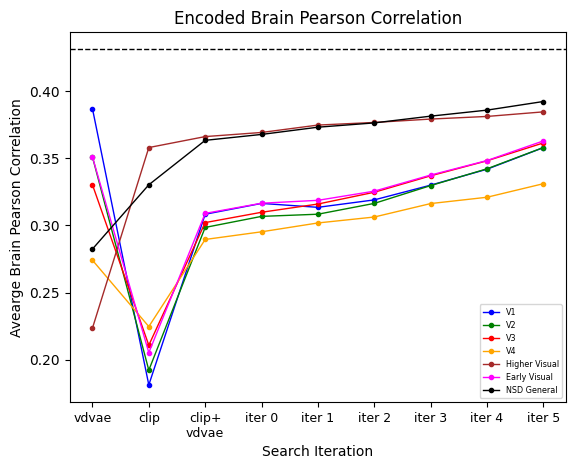

In [3]:
# Average Iteration Brain Region Plot

import matplotlib.pyplot as plt

brain_correlation_V1 = []
brain_correlation_V2 = []
brain_correlation_V3 = []
brain_correlation_V4 = []
brain_correlation_early_visual = []
brain_correlation_higher_visual = []
brain_correlation_unmasked = []
brain_correlation_ground_truth = []

folders = {"vdvae_distribution" : 2, "clip_distribution" : 1, "clip+vdvae_distribution" : 3, "iter_0" : 4, "iter_1" : 5 , "iter_2" : 6, "iter_3" : 7, "iter_4" : 8, "iter_5" : 9}
x = ["vdvae", "clip", "clip+\nvdvae", "iter 0", "iter 1", "iter 2", "iter 3", "iter 4", "iter 5"]

for folder, sample_indicator in folders.items():
    
    iteration_val_v1 = df.loc[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation V1'].mean()
    iteration_val_v2 = df.loc[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation V2'].mean()
    iteration_val_v3 = df.loc[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation V3'].mean()
    iteration_val_v4 = df.loc[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation V4'].mean()
    iteration_val_ev = df.loc[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation Early Visual'].mean()
    iteration_val_hv = df.loc[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation Higher Visual'].mean()
    iteration_val_unmasked = df.loc[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation NSD General'].mean()
    
    brain_correlation_V1.append(iteration_val_v1)
    brain_correlation_V2.append(iteration_val_v2)
    brain_correlation_V3.append(iteration_val_v3)
    brain_correlation_V4.append(iteration_val_v4)
    brain_correlation_early_visual.append(iteration_val_ev)
    brain_correlation_higher_visual.append(iteration_val_hv)
    brain_correlation_unmasked.append(iteration_val_unmasked)
    

# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V1'].mean(), color = 'blue', linestyle = 'dashed', linewidth=1)
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V2'].mean(), color = 'green', linestyle = 'dashed', linewidth=1)
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V3'].mean(), color = 'red',linestyle = 'dashed', linewidth=1)
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V4'].mean(), color = 'orange',linestyle = 'dashed', linewidth=1)
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Higher Visual'].mean(), color = 'brown', linestyle = 'dashed', linewidth=1)
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Early Visual'].mean(),  color = 'magenta',linestyle = 'dashed', linewidth=1)
plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation NSD General'].mean(), color = 'black', linestyle = 'dashed', linewidth=1)

plt.plot(brain_correlation_V1, marker='.', color = 'blue', label = 'V1', linewidth=1)
plt.plot(brain_correlation_V2, marker='.', color = 'green',label = 'V2', linewidth=1)
plt.plot(brain_correlation_V3, marker='.', color = 'red',  label = 'V3', linewidth=1)
plt.plot(brain_correlation_V4, marker='.', color = 'orange', label = 'V4', linewidth=1)
plt.plot(brain_correlation_higher_visual, marker='.', color = 'brown', label = 'Higher Visual', linewidth=1)
plt.plot(brain_correlation_early_visual, marker='.',  color = 'magenta', label = 'Early Visual', linewidth=1)
plt.plot(brain_correlation_unmasked, marker='.',  color = 'black', label = 'NSD General', linewidth=1)
plt.xticks(range(len(x)), x,fontsize=9)

plt.legend(fontsize = "xx-small")
plt.xlabel("Search Iteration")
plt.ylabel("Avearge Brain Pearson Correlation")
plt.title("Encoded Brain Pearson Correlation")
mpl.rcParams['figure.dpi'] = 300


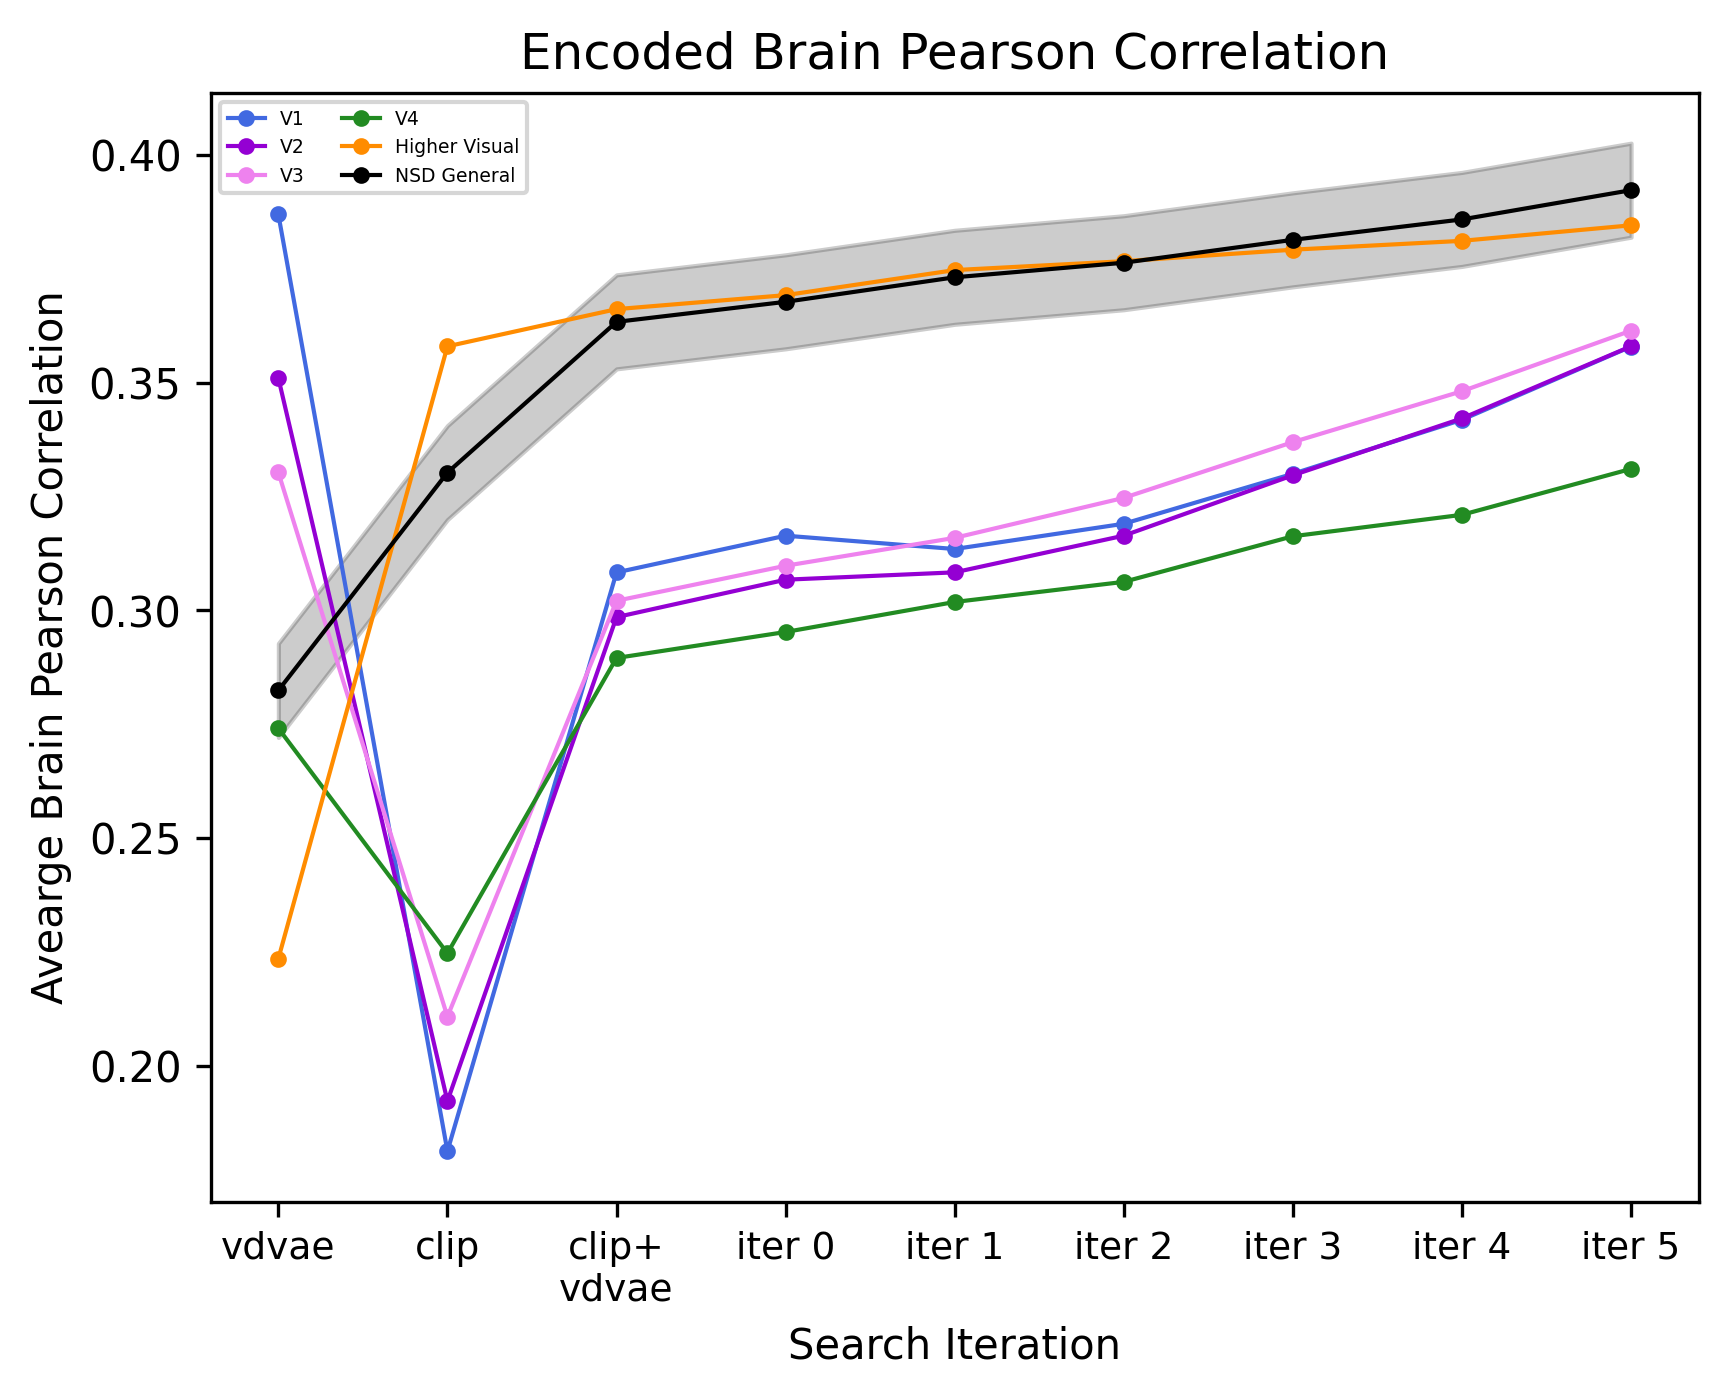

In [21]:
# Average Iteration Brain Region Plot

brain_correlation_V1 = []
brain_correlation_V2 = []
brain_correlation_V3 = []
brain_correlation_V4 = []
brain_correlation_early_visual = []
brain_correlation_higher_visual = []
brain_correlation_unmasked = []
brain_correlation_ground_truth = []

y_v1 = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V1'].mean()
y_v2 = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V2'].mean()
y_v3 = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V3'].mean()
y_v4 = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V4'].mean()
y_ev = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Early Visual'].mean()
y_hv = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Higher Visual'].mean()
y_unmasked = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation NSD General'].mean()

v1_set = True
v2_set = True
v3_set = True
v4_set = True
ev_set = True
hv_set = True
unmasked_set = True

x_v1 = 0 
x_v2 = 0 
x_v3 = 0 
x_v4 = 0 
x_ev = 0 
x_hv = 0 
x_umasked = 0 

folders = {"vdvae_distribution" : 2, "clip_distribution" : 1, "clip+vdvae_distribution" : 3, "iter_0" : 4, "iter_1" : 5 , "iter_2" : 6, "iter_3" : 7, "iter_4" : 8, "iter_5" : 9}
x = ["vdvae", "clip", "clip+\nvdvae", "iter 0", "iter 1", "iter 2", "iter 3", "iter 4", "iter 5"]
iteration = 0


for folder, sample_indicator in folders.items():
    
    iteration_val_v1 = df.loc[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation V1'].mean()
    iteration_val_v2 = df.loc[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation V2'].mean()
    iteration_val_v3 = df.loc[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation V3'].mean()
    iteration_val_v4 = df.loc[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation V4'].mean()
    iteration_val_ev = df.loc[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation Early Visual'].mean()
    iteration_val_hv = df.loc[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation Higher Visual'].mean()
    iteration_val_unmasked = df.loc[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation NSD General'].mean()
    
    brain_correlation_V1.append(iteration_val_v1)
    brain_correlation_V2.append(iteration_val_v2)
    brain_correlation_V3.append(iteration_val_v3)
    brain_correlation_V4.append(iteration_val_v4)
    brain_correlation_early_visual.append(iteration_val_ev)
    brain_correlation_higher_visual.append(iteration_val_hv)
    brain_correlation_unmasked.append(iteration_val_unmasked)
    
    if(iteration_val_v1 > y_v1 and v1_set):
        x_v1 = iteration - 1
        v1_set = False
        
    if(iteration_val_v2 > y_v2 and v2_set):
        x_v2 = iteration - 1
        v2_set = False
        
    if(iteration_val_v3 > y_v3 and v3_set):
        x_v3 = iteration - 1
        v3_set = False
        
    if(iteration_val_v4 > y_v4 and v4_set):
        x_v4 = iteration - 1
        v4_set = False
        
    if(iteration_val_ev > y_ev and ev_set):
        x_ev = iteration - 1
        ev_set = False
        
    if(iteration_val_hv > y_hv and hv_set):
        x_hv = iteration - 1
        hv_set = False
        
    if(iteration_val_unmasked > y_unmasked and unmasked_set):
        x_unmasked = iteration - 1
        unmasked_set = False
        
    iteration += 1
    
# print(df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Unmasked'].mean())
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Unmasked'].mean(), linestyle = 'dashed', label = 'Brain Correlation Unmasked')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V1'].mean(), linestyle = '-', label = 'Brain Correlation V1')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V2'].mean(), linestyle = '-', label = 'Brain Correlation V2')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V3'].mean(), linestyle = '-', label = 'Brain Correlation V3')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V4'].mean(), linestyle = '-', label = 'Brain Correlation V4')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Higher Visual'].mean(), linestyle = '-', label = 'Brain Correlation Higher Visual')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Early Visual'].mean(), linestyle = '-', label = 'Brain Correlation Higher Visual')


N = 9
#x = np.array([0,1,2,3,4,5,6,7,8,9])
# y = np.array(brain_correlation_unmasked)
# a, b = np.polyfit(x, brain_correlation_unmasked, deg=1)
# y_est = a * x + b
# y_err = st.t.interval(alpha=0.95, df=len(y)-1, loc=np.mean(y), scale=st.sem(y))
# print(y_err[0])
# print(y_err[1])

y_un = np.array(brain_correlation_unmasked)
ci_un = 0.95 * np.std(y_un) / math.sqrt(N)


# def mean_confidence_interval(data, confidence=0.95):
#     a = 1.0 * np.array(data)
#     n = len(a)
#     m, se = np.mean(a), scipy.stats.sem(a)
#     h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
#     return m, m-h, m+h

# mean, lower, upper = [],[],[]
# ci = 0.95

# m, ml, mu = mean_confidence_interval(y, ci)
# mean.append(m)
# lower.append(ml)
# upper.append(mu)


plt.plot(brain_correlation_V1, marker='.', label = 'V1', linewidth=1, color = "royalblue")
plt.plot(brain_correlation_V2, marker='.', label = 'V2', linewidth=1, color = "darkviolet")
plt.plot(brain_correlation_V3, marker='.', label = 'V3', linewidth=1, color = "red")
plt.plot(brain_correlation_V4, marker='.', label = 'V4', linewidth=1, color = "forestgreen")
#plt.plot(brain_correlation_early_visual, marker='.', label = 'Early Visual', linewidth=1, color = "red")
plt.plot(brain_correlation_higher_visual, marker='.', label = 'Higher Visual', linewidth=1, color = "darkorange")
plt.plot(brain_correlation_unmasked, marker='.', label = 'NSD General', linewidth=1, color = "black")
plt.xticks(range(len(x)), x,fontsize=9)
# plt.fill_between(x, y_err[0], y_err[0], color='dimgray', alpha=0.2)
# plt.fill_between(x, upper, lower, color='dimgray', alpha=0.2)
plt.fill_between(x, (y_un-ci_un), (y_un+ci_un), color='black', alpha=.2)
# plt.fill_between(x, (y_hi-ci_hi), (y_hi+ci_hi), color='darkorange', alpha=.2)
# plt.fill_between(x, (y_er-ci_er), (y_er+ci_er), color='red', alpha=.2)
# plt.fill_between(x, (y_vo-ci_vo), (y_vo+ci_vo), color='royalblue', alpha=.2)
# plt.fill_between(x, (y_vt-ci_vt), (y_vt+ci_vt), color='darkviolet', alpha=.2)
# plt.fill_between(x, (y_vth-ci_vth), (y_vth+ci_vth), color='violet', alpha=.2)
# plt.fill_between(x, (y_vf-ci_vf), (y_vf+ci_vf), color='forestgreen', alpha=.2)

# plt.plot([7.25, 7 + 1], [y_v1, y_v1] , color = "royalblue", linestyle="dashed", linewidth=2)
# plt.plot([7.25, 7 + 1], [y_v2, y_v2] , color = "darkviolet", linestyle="dashed", linewidth=2)
# plt.plot([7.25, 7 + 1], [y_v3, y_v3] , color = "violet", linestyle="dashed", linewidth=2)
# plt.plot([x_v4 + 0.25, x_v4 + 1], [y_v4, y_v4] , color = 'forestgreen', linestyle="dashed", linewidth=2)
# plt.plot([7.25, 7 + 1], [y_ev - 0.002, y_ev - 0.002] , color = 'red', linestyle="dashed", linewidth=2)
# plt.plot([x_hv - 0.25, x_hv + 0.50], [y_hv, y_hv] , color = "darkorange", linestyle="dashed", linewidth=2)
# plt.plot([x_unmasked + 0.5, x_unmasked + 1.25], [y_unmasked, y_unmasked] , color = 'black', linestyle="dashed", linewidth=2, label="Ground Truth Image")
#plt.axhline(x = [1,3], y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Unmasked'].mean(), linestyle = 'dashed', label = 'Brain Correlation Unmasked')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V1'].mean(), linestyle = '-', label = 'Brain Correlation V1')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V2'].mean(), linestyle = '-', label = 'Brain Correlation V2')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V3'].mean(), linestyle = '-', label = 'Brain Correlation V3')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V4'].mean(), linestyle = '-', label = 'Brain Correlation V4')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Higher Visual'].mean(), linestyle = '-', label = 'Brain Correlation Higher Visual')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Early Visual'].mean(), linestyle = '-', label = 'Brain Correlation Higher Visual')
leg = plt.legend(loc="upper left", ncol = 2, fontsize = "4.5")
# leg.legendHandles[7].set_color('silver')
plt.xlabel("Search Iteration")
plt.ylabel("Avearge Brain Pearson Correlation")
plt.title("Encoded Brain Pearson Correlation")
mpl.rcParams['figure.dpi'] = 2500


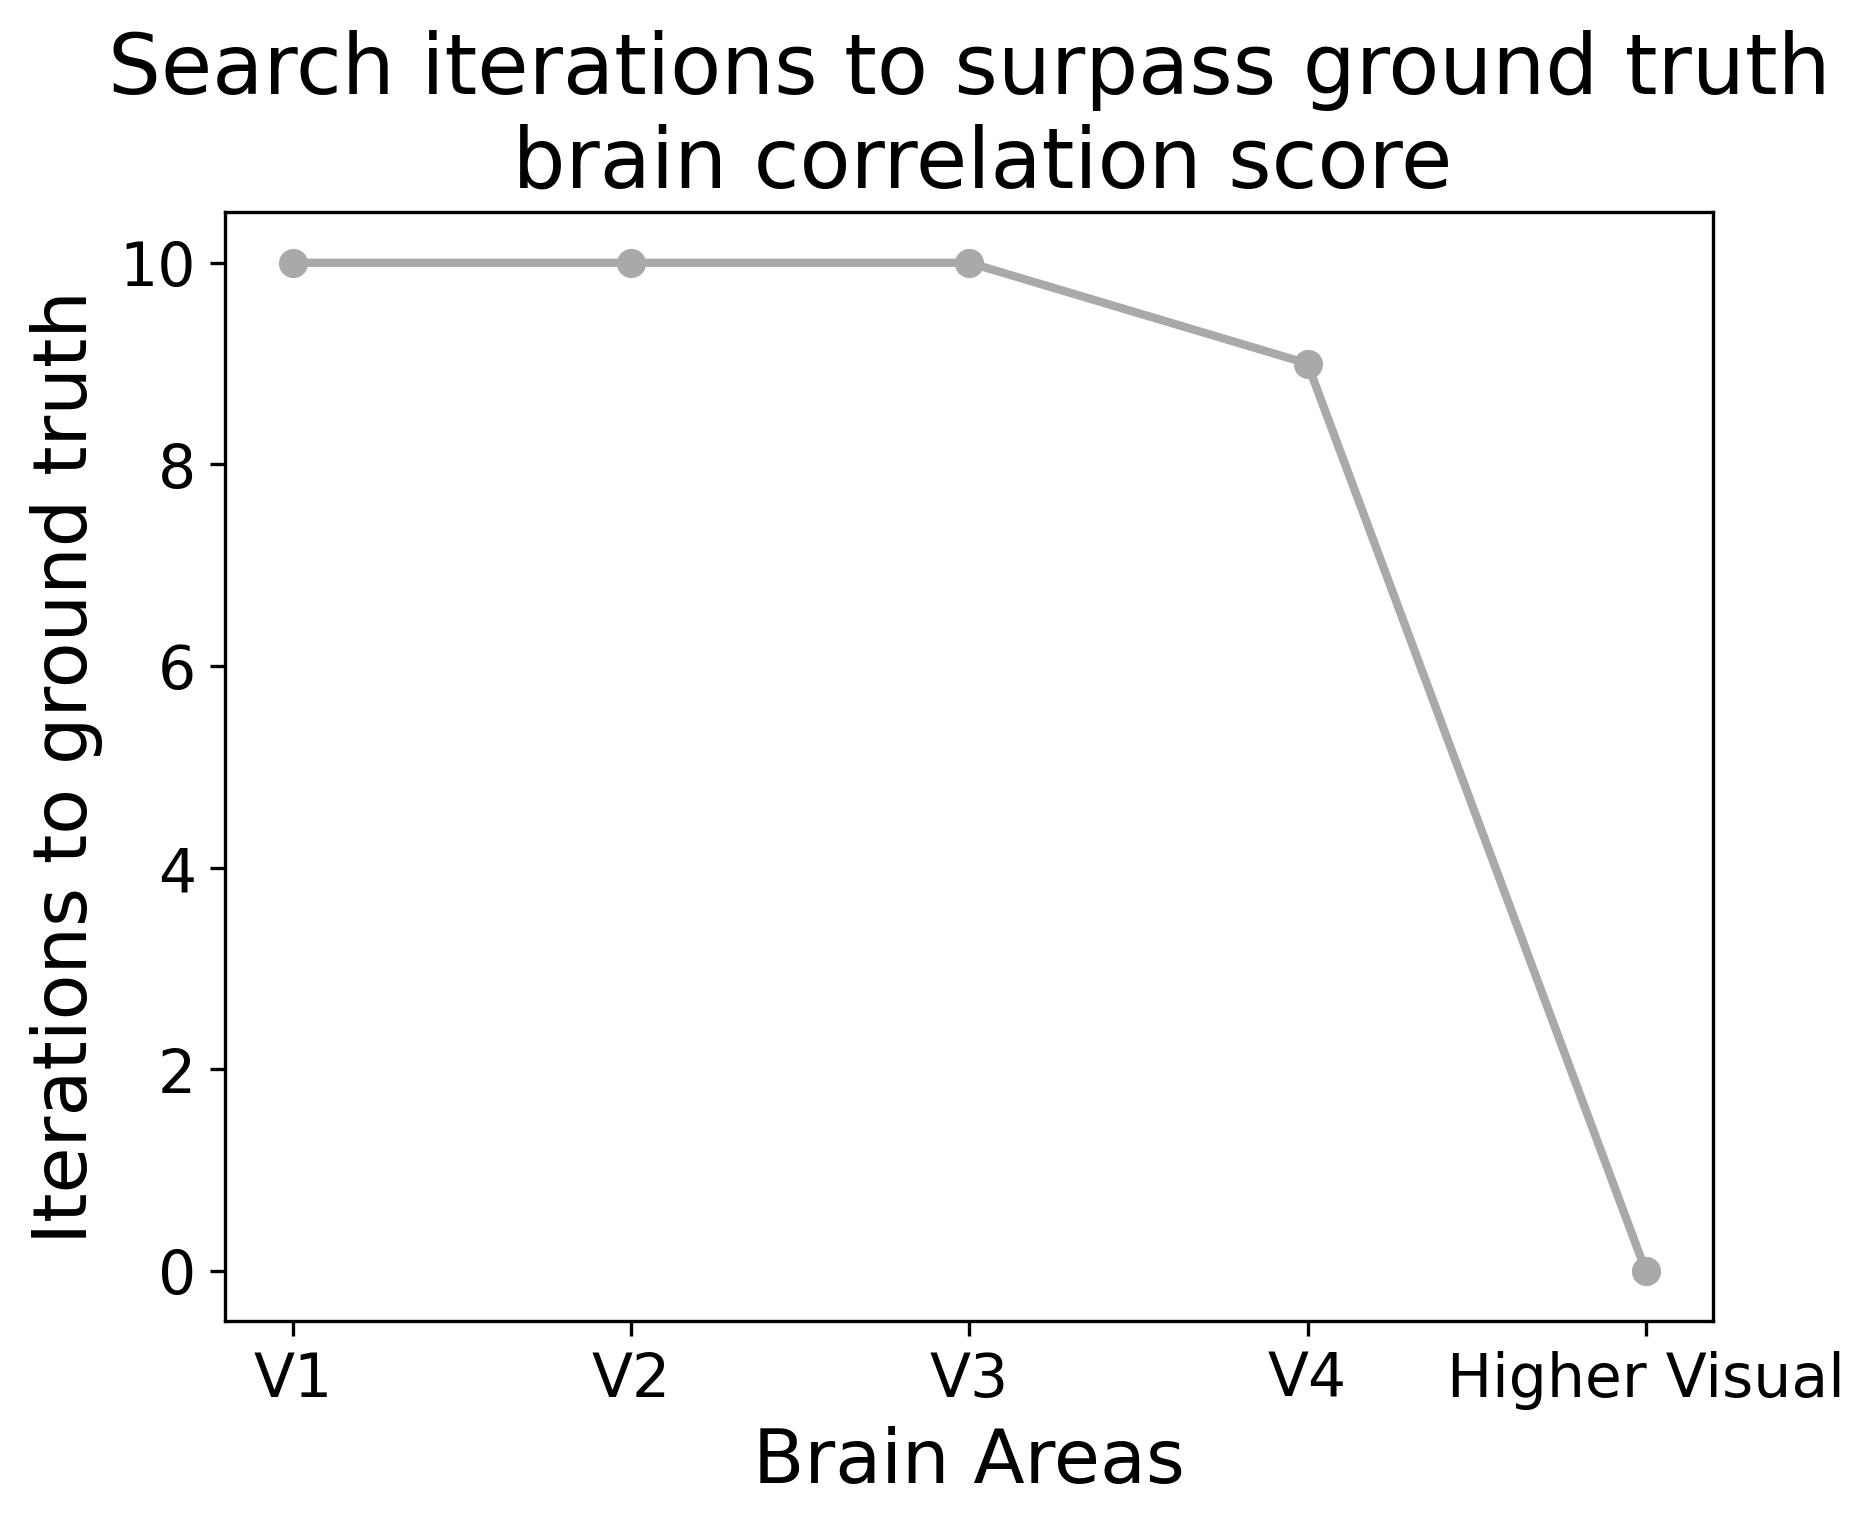

In [42]:
# Search iterations to Ground Truth

x_iter_values = []

x_iter_values.append(10)
x_iter_values.append(10)
x_iter_values.append(10)
x_iter_values.append(9)
x_iter_values.append(0)

x_labels = ['V1', 'V2', 'V3', 'V4', 'Higher Visual']
x_axis = np.arange(len(x_labels))
# y_labels = ["0", "2", "4", "6", "8", "10 >="]
# y_axis = np.arange(len(y_labels))

# x_iter_values.append(0)
# x_iter_values.append(x_v4)
# x_iter_values.append(x_v3)
# x_iter_values.append(x_v2)
# x_iter_values.append(9)

# x_labels = ['Higher Visual', 'V4', 'V3', 'V2', 'V1']
plt.xticks(x_axis, x_labels)
# plt.yticks(y_axis, y_labels)
plt.plot(x_iter_values, marker='o', linewidth=2, color = "darkgray")
plt.xlabel("Brain Areas", fontsize=18)
plt.ylabel("Iterations to ground truth", fontsize=18)
plt.title("Search iterations to surpass ground truth\n brain correlation score", fontsize=20)
mpl.rcParams['figure.dpi'] = 300

In [10]:
# Bar Plot Sample Counts 

idx = [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 
        64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 
        109, 110, 111, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
        147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 
        182, 183, 184, 185, 186, 188, 189, 190, 191, 192, 193, 194, 195, 196, 198, 199, 200, 201, 202, 203, 205, 206, 207, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 
        221, 222, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 256, 257, 
        258, 259, 261, 262, 263, 264, 265, 266, 267, 268, 270, 272, 273, 274, 275, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 
        297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 
        333, 334, 335, 336, 337, 338, 339, 341, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 364, 365, 366, 367, 368, 369, 370, 
        371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 393, 394, 395, 396, 397, 398, 400, 401, 402, 403, 404, 406, 407, 408, 
        409, 410, 411, 412, 413, 414, 415, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 
        447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 481, 482, 
        483, 484, 485, 486, 487, 488, 489, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 
        521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 547, 548, 549, 551, 552, 553, 554, 555, 556, 557, 
        558, 559, 560, 561, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 
        594, 595, 596, 597, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 616, 617, 618, 619, 620, 621, 622, 624, 625, 626, 627, 628, 629, 630, 631, 632, 
        633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 655, 656, 657, 659, 661, 662, 663, 664, 666, 667, 668, 669, 670, 671, 
        672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 694, 695, 696, 698, 699, 700, 701, 702, 703, 704, 705, 706, 708, 709, 
        710, 711, 712, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 
        747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 782, 783, 
        784, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819,
        820, 821, 822, 823, 824, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 838, 839, 840, 841, 842, 843, 844, 845, 847, 848, 849, 851, 852, 854, 855, 856, 857, 858, 859,
        861, 862, 863, 864, 865, 866, 867, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 892, 893, 894, 895, 896, 897, 
        898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 
        934, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 
        971, 974, 976, 977, 978, 979, 980, 981]

v1 = [0, 0, 0, 0, 0, 0, 0, 0, 0]
v2 = [0, 0, 0, 0, 0, 0, 0, 0, 0]
v3 = [0, 0, 0, 0, 0, 0, 0, 0, 0]
v4 = [0, 0, 0, 0, 0, 0, 0, 0, 0]
ev = [0, 0, 0, 0, 0, 0, 0, 0, 0]
hv = [0, 0, 0, 0, 0, 0, 0, 0, 0]
nsd = [0, 0, 0, 0, 0, 0, 0, 0, 0]

#folders = {"vdvae_distribution" : 0, "clip_distribution" : 1, "clip+vdvae_distribution" : 2, "iter_0" : 3, "iter_1" : 4, "iter_2" : 5, "iter_3" : 6, "iter_4" : 7 , "iter_5": 8}
#folders = {"clip_distribution" : 1, "vdvae_distribution" : 2, "clip+vdvae_distribution" : 3, "iter_0" : 4, "iter_1" : 5 , "iter_2" : 6, "iter_3" : 7, "iter_4" : 8, "iter_5" : 9}
folders = {"vdvae_distribution" : 2, "clip_distribution" : 1, "clip+vdvae_distribution" : 3, "iter_0" : 4, "iter_1" : 5 , "iter_2" : 6, "iter_3" : 7, "iter_4" : 8, "iter_5" : 9}
list_indicator = {2 : 0, 1 : 1, 3 : 2, 4 : 3, 5 : 4 , 6 : 5, 7 : 6, 8 : 7, 9 : 8}

ground_truth_samples = df.loc[(df['Sample Indicator'] == 0)]

# Append rows to an empty DataFrame
for i in tqdm(idx, desc="creating bar graph numbers"):
        
    ground_truth_v1     = float(ground_truth_samples.loc[(ground_truth_samples['ID'] == i)]['Brain Correlation V1'])
    ground_truth_v2     = float(ground_truth_samples.loc[(ground_truth_samples['ID'] == i)]['Brain Correlation V2'])
    ground_truth_v3     = float(ground_truth_samples.loc[(ground_truth_samples['ID'] == i)]['Brain Correlation V3'])
    ground_truth_v4     = float(ground_truth_samples.loc[(ground_truth_samples['ID'] == i)]['Brain Correlation V4'])
    ground_truth_ev     = float(ground_truth_samples.loc[(ground_truth_samples['ID'] == i)]['Brain Correlation Early Visual'])
    ground_truth_hv     = float(ground_truth_samples.loc[(ground_truth_samples['ID'] == i)]['Brain Correlation Higher Visual'])
    ground_truth_nsd    = float(ground_truth_samples.loc[(ground_truth_samples['ID'] == i)]['Brain Correlation NSD General'])
    
    single_sample = df.loc[(df['ID'] == i)]
    single_sample = single_sample[:-2]
    
    for folder, value in folders.items():
    
        v1_bc = single_sample.loc[(single_sample['Sample Indicator'] == value)]['Brain Correlation V1'].mean()
        v2_bc = single_sample.loc[(single_sample['Sample Indicator'] == value)]['Brain Correlation V2'].mean()
        v3_bc = single_sample.loc[(single_sample['Sample Indicator'] == value)]['Brain Correlation V3'].mean()
        v4_bc = single_sample.loc[(single_sample['Sample Indicator'] == value)]['Brain Correlation V4'].mean()
        ev_bc = single_sample.loc[(single_sample['Sample Indicator'] == value)]['Brain Correlation Early Visual'].mean()
        hv_bc = single_sample.loc[(single_sample['Sample Indicator'] == value)]['Brain Correlation Higher Visual'].mean()
        nsd_bc = single_sample.loc[(single_sample['Sample Indicator'] == value)]['Brain Correlation NSD General'].mean()

        if(v1_bc > ground_truth_v1):
            v1[list_indicator[value]] += 1
            
        if(v2_bc > ground_truth_v2):
            v2[list_indicator[value]] += 1
            
        if(v3_bc > ground_truth_v3):
            v3[list_indicator[value]] += 1
            
        if(v4_bc > ground_truth_v4):
            v4[list_indicator[value]] += 1
        
        if(ev_bc > ground_truth_ev):
            ev[list_indicator[value]] += 1
            
        if(hv_bc > ground_truth_hv):
            hv[list_indicator[value]] += 1
            
        if(nsd_bc > ground_truth_nsd):
            nsd[list_indicator[value]] += 1
            
print(v1)
print(v2)
print(v3)
print(v4)
print(ev)
print(hv)
print(nsd)
    



creating bar graph numbers:   0%|          | 0/897 [00:00<?, ?it/s]/tmp/ipykernel_8059/1933675742.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ground_truth_v1     = float(ground_truth_samples.loc[(ground_truth_samples['ID'] == i)]['Brain Correlation V1'])
/tmp/ipykernel_8059/1933675742.py:47: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ground_truth_v2     = float(ground_truth_samples.loc[(ground_truth_samples['ID'] == i)]['Brain Correlation V2'])
/tmp/ipykernel_8059/1933675742.py:48: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ground_truth_v3     = float(ground_truth_samples.loc[(ground_truth_samples['ID'] == i)]['Brain Correlation V3'])
/tmp/ipykernel_8059/1933675742.py:49: FutureW

creating bar graph numbers: 100%|██████████| 897/897 [00:16<00:00, 55.54it/s]

[45, 5, 8, 11, 8, 7, 10, 10, 10]
[93, 12, 32, 33, 28, 31, 39, 37, 50]
[126, 27, 66, 74, 73, 77, 91, 109, 130]
[151, 81, 130, 143, 169, 173, 200, 221, 247]
[58, 5, 16, 17, 19, 15, 23, 26, 30]
[80, 192, 230, 244, 271, 289, 299, 308, 333]
[56, 39, 78, 96, 89, 96, 114, 124, 139]


In [15]:
# Create Bar Plots

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker



# x = ["vdvae", "clip", "clip+\nvdvae", "iter 0", "iter 1", "iter 2", "iter 3", "iter 4", "iter 5"]
# x = ["V1", "V2", "V3", "V4", "Early \nVisual", "Higher \nVisual", "NSD \nGeneral"]

# vdvae       = [v1[0], v2[0], v3[0], v4[0], ev[0], hv[0], nsd[0]]
# clip        = [v1[1], v2[1], v3[1], v4[1], ev[1], hv[1], nsd[1]]
# clip_vdvae  = [v1[2], v2[2], v3[2], v4[2], ev[2], hv[2], nsd[2]]
# iter_0      = [v1[3], v2[3], v3[3], v4[3], ev[3], hv[3], nsd[3]]
# iter_1      = [v1[4], v2[4], v3[4], v4[4], ev[4], hv[4], nsd[4]]
# iter_2      = [v1[5], v2[5], v3[5], v4[5], ev[5], hv[5], nsd[5]]
# iter_3      = [v1[6], v2[6], v3[6], v4[6], ev[6], hv[6], nsd[6]]
# iter_4      = [v1[7], v2[7], v3[7], v4[7], ev[7], hv[7], nsd[7]]
# iter_5      = [v1[8], v2[8], v3[8], v4[8], ev[8], hv[8], nsd[8]]


x = ["V1", "V2", "V3", "V4", "Higher \nVisual", "NSD \nGeneral"]

vdvae       = [v1[0], v2[0], v3[0], v4[0], hv[0], nsd[0]]
clip        = [v1[1], v2[1], v3[1], v4[1], hv[1], nsd[1]]
clip_vdvae  = [v1[2], v2[2], v3[2], v4[2], hv[2], nsd[2]]
iter_0      = [v1[3], v2[3], v3[3], v4[3], hv[3], nsd[3]]
iter_1      = [v1[4], v2[4], v3[4], v4[4], hv[4], nsd[4]]
iter_2      = [v1[5], v2[5], v3[5], v4[5], hv[5], nsd[5]]
iter_3      = [v1[6], v2[6], v3[6], v4[6], hv[6], nsd[6]]
iter_4      = [v1[7], v2[7], v3[7], v4[7], hv[7], nsd[7]]
iter_5      = [v1[8], v2[8], v3[8], v4[8], hv[8], nsd[8]]


x_axis = np.arange(len(x))

n = 6
r = np.arange(n)
width = 0.10


plt.bar(r - width * 4, vdvae, color = '#e3342f',
        width = width, edgecolor = 'black',
        label='VDVAE')
plt.bar(r - width * 3, clip, color = '#f6993f',
        width = width, edgecolor = 'black',
        label='CLIP')
plt.bar(r - width * 2, clip_vdvae, color = '#ffed4a',
        width = width, edgecolor = 'black',
        label='CLIP+VDVAE')
plt.bar(r - width, iter_0, color = '#38c172',
        width = width, edgecolor = 'black',
        label='iter 0')
plt.bar(r, iter_1, color = '#4dc0b5',
        width = width, edgecolor = 'black',
        label='iter 1')
plt.bar(r + width, iter_2, color = '#3490dc',
        width = width, edgecolor = 'black',
        label='iter 2')
plt.bar(r + width * 2, iter_3, color = '#6574cd',
        width = width, edgecolor = 'black',
        label='iter 3')
plt.bar(r + width * 3, iter_4, color = '#9561e2',
        width = width, edgecolor = 'black',
        label='iter 4')
plt.bar(r + width * 4, iter_5, color = '#f66d9b',
        width = width, edgecolor = 'black',
        label='iter 5')

plt.xticks(x_axis, x)
plt.xlabel("Brain Areas")
plt.ylabel("Percentage of samples aligned to brain activity")
plt.title("Sample Distributions Alighned to Brain Activity (N = 897)")
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(897))
#plt.xlim(897)
plt.legend(fontsize = "x-small")
mpl.rcParams['figure.dpi'] = 500
plt.show()





In [ ]:
# CNN to brain correlation plot


plt.scatter(x, y)
plt.xlabel("Brain Correlation", fontsize=18)
plt.ylabel("AlexNet 2", fontsize=18)
plt.title("CNN to brain correlation plot", fontsize=20)
mpl.rcParams['figure.dpi'] = 300

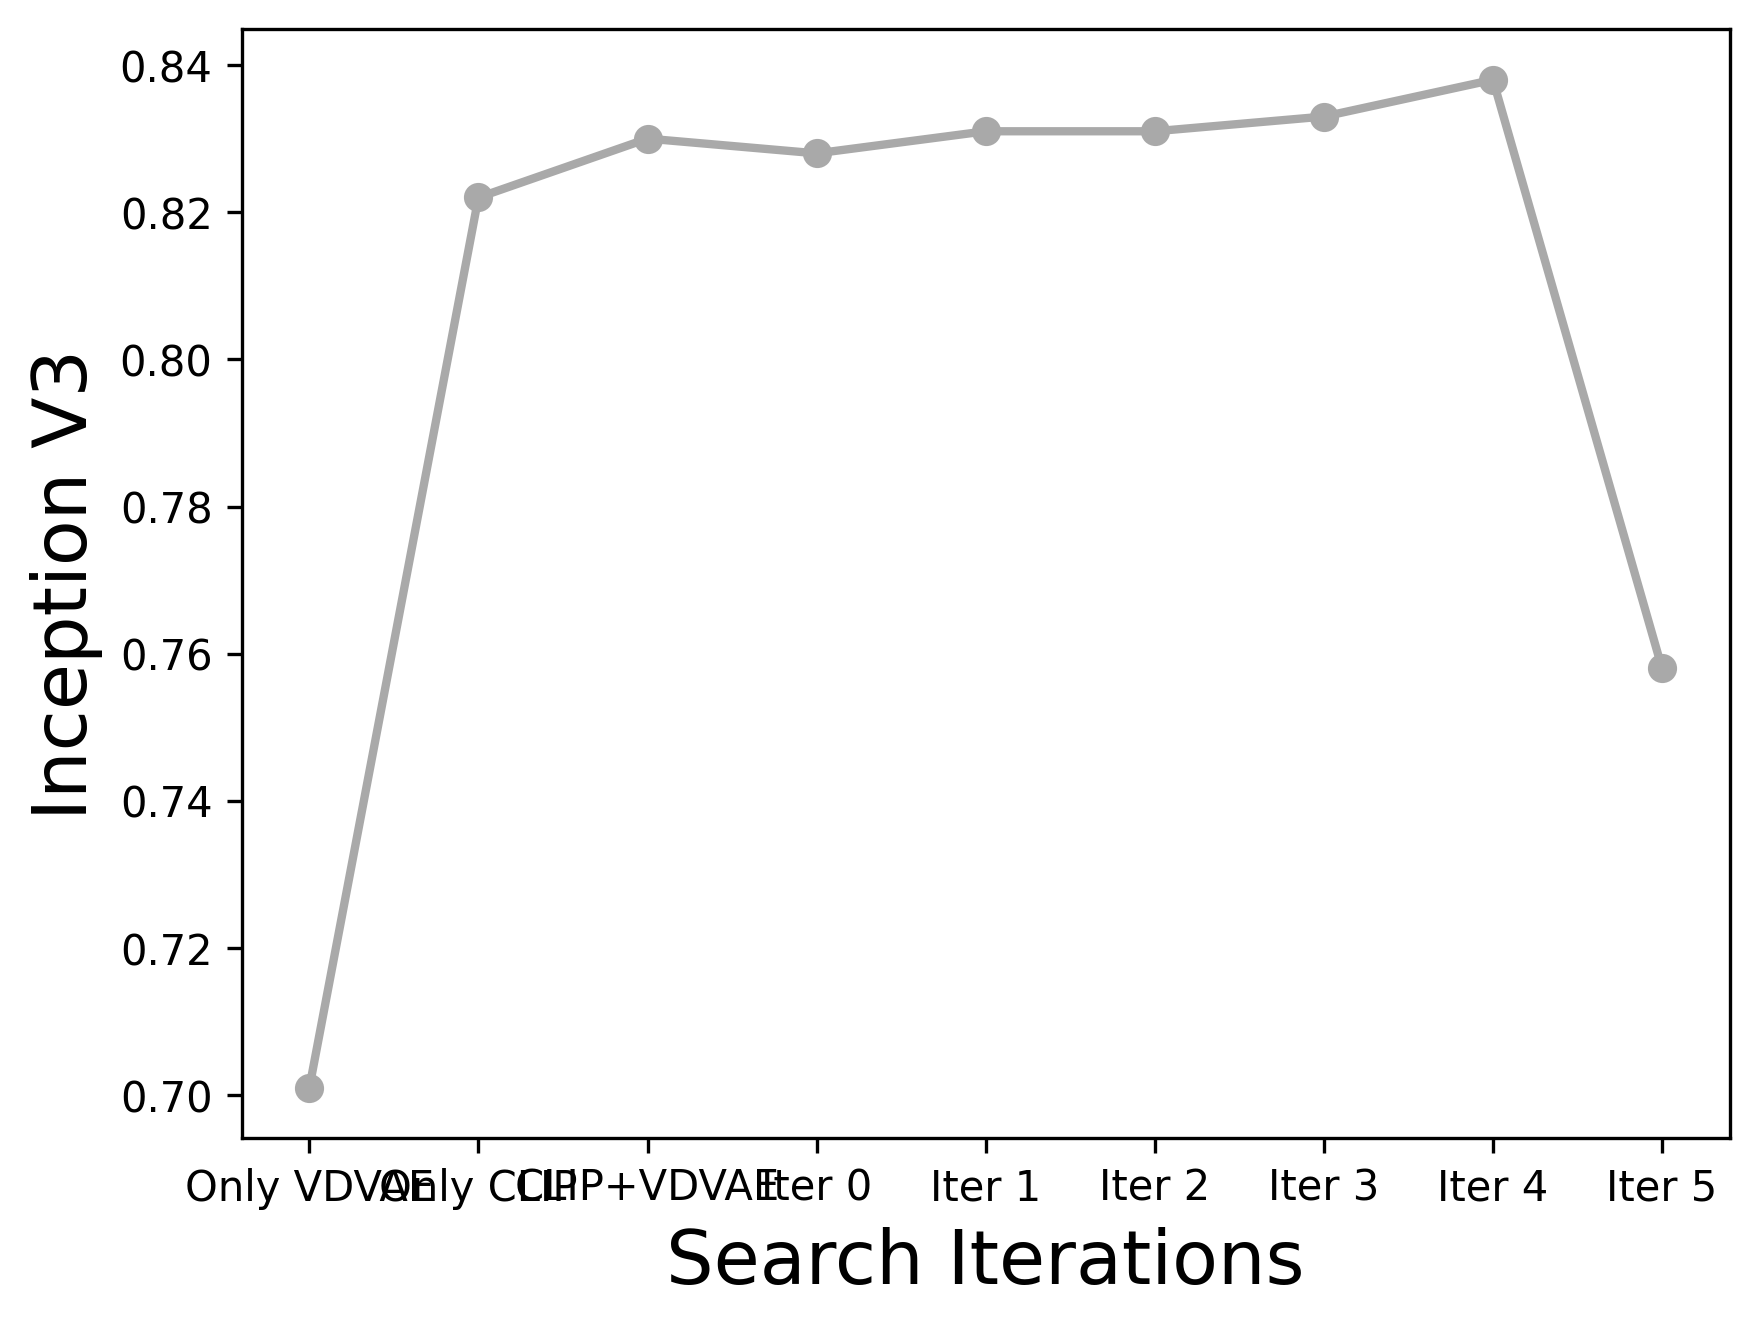

In [5]:
x_iter_values = []

x_iter_values.append(.701)
x_iter_values.append(.822)
x_iter_values.append(.830)
x_iter_values.append(.828)
x_iter_values.append(.831)
x_iter_values.append(.831)
x_iter_values.append(.833)
x_iter_values.append(.838)
x_iter_values.append(.758)

x_labels = ['Only VDVAE', 'Only CLIP', 'CLIP+VDVAE', 'Iter 0', 'Iter 1','Iter 2','Iter 3','Iter 4','Iter 5']
x_axis = np.arange(len(x_labels))
# y_labels = ["0", "2", "4", "6", "8", "10 >="]
# y_axis = np.arange(len(y_labels))

# x_iter_values.append(0)
# x_iter_values.append(x_v4)
# x_iter_values.append(x_v3)
# x_iter_values.append(x_v2)
# x_iter_values.append(9)

# x_labels = ['Higher Visual', 'V4', 'V3', 'V2', 'V1']
plt.xticks(x_axis, x_labels)
# plt.yticks(y_axis, y_labels)
plt.plot(x_iter_values, marker='o', linewidth=2, color = "darkgray")
plt.xlabel("Search Iterations", fontsize=18)
plt.ylabel("Inception V3", fontsize=18)
mpl.rcParams['figure.dpi'] = 300

/tmp/ipykernel_74120/3660902820.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  iteration_val_nsd = sample[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation NSD General'].var()
/tmp/ipykernel_74120/3660902820.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  iteration_val_nsd = sample[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation NSD General'].var()
/tmp/ipykernel_74120/3660902820.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  iteration_val_nsd = sample[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation NSD General'].var()
/tmp/ipykernel_74120/3660902820.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  iteration_val_nsd = sample[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation NSD General'].var()
/tmp/ipykernel_74120/3660902820.py:64: UserWarning: Boolean Series key will be reind

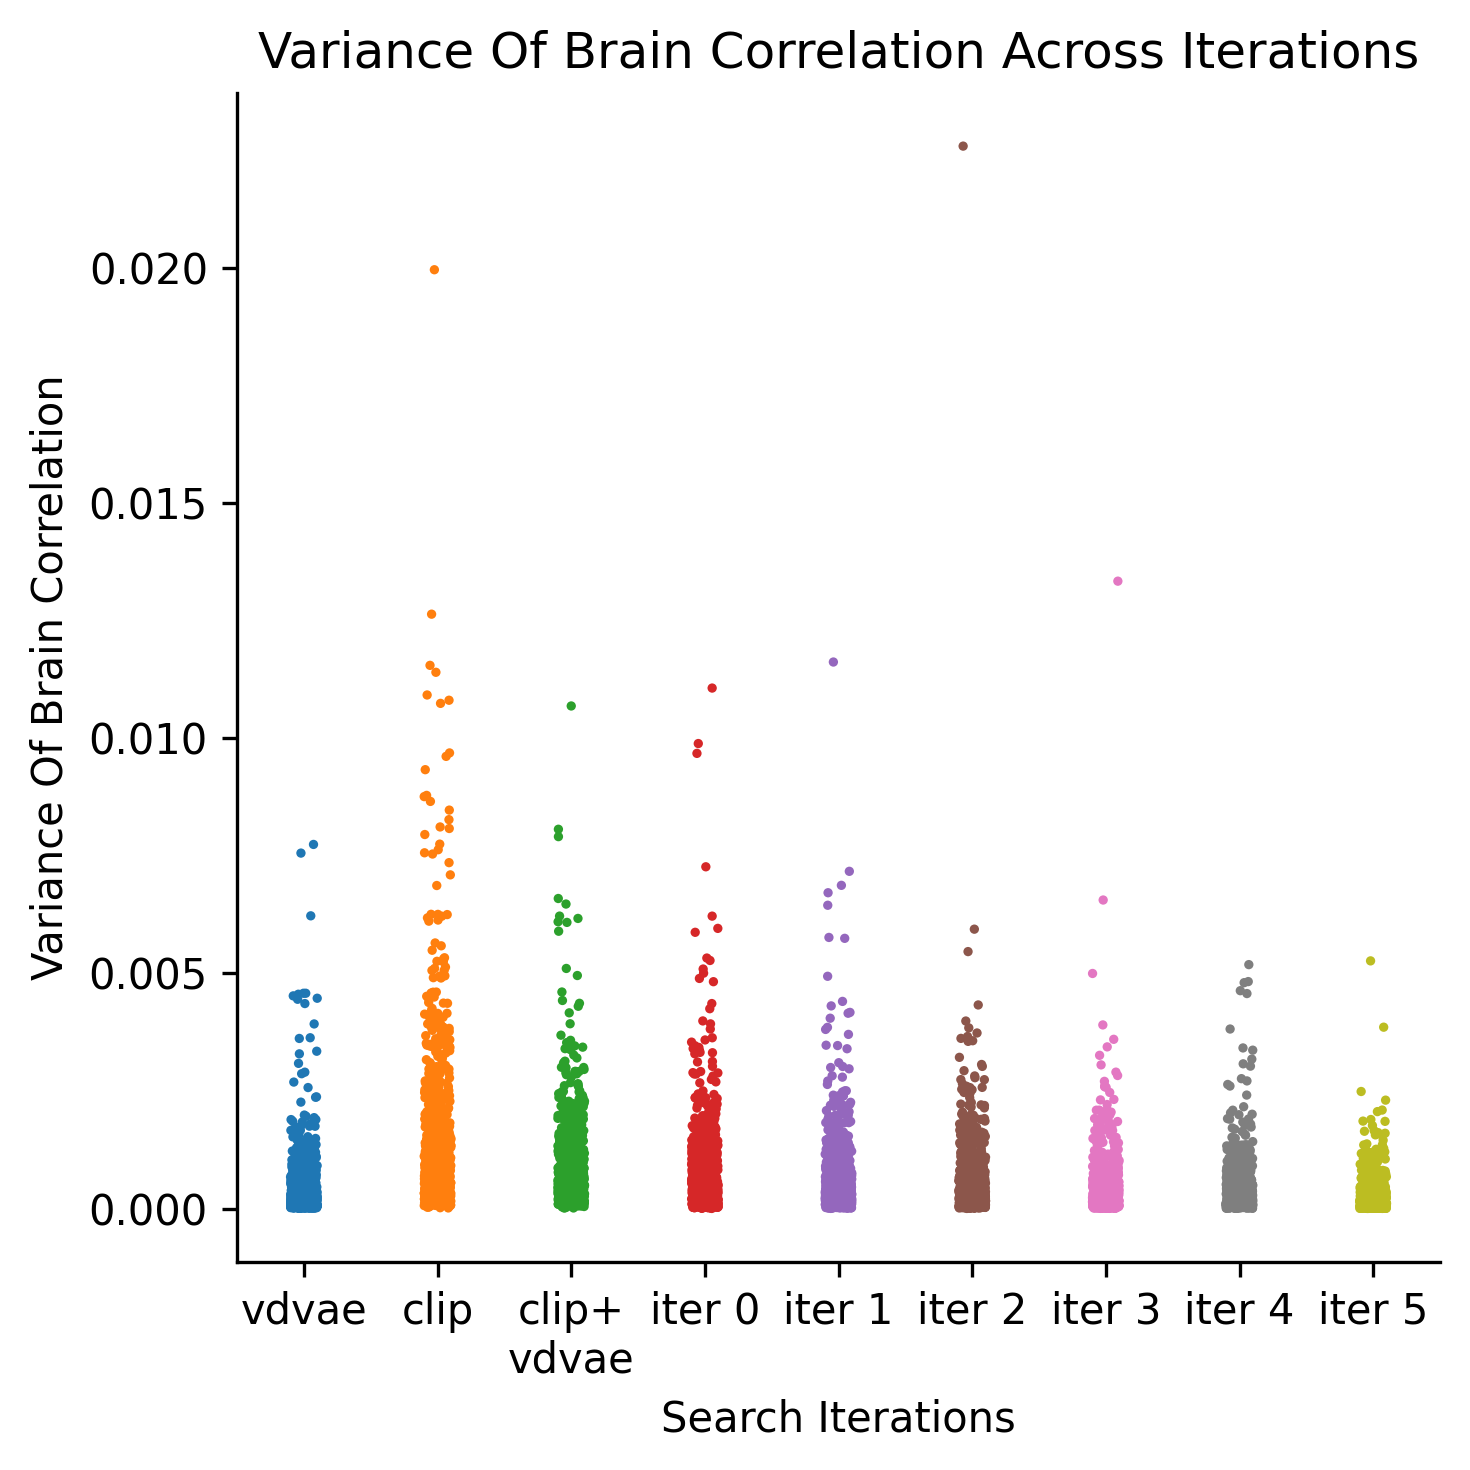

In [82]:
# Average Iteration Brain Region Plot

idx = [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 
        64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 
        109, 110, 111, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
        147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 
        182, 183, 184, 185, 186, 188, 189, 190, 191, 192, 193, 194, 195, 196, 198, 199, 200, 201, 202, 203, 205, 206, 207, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 
        221, 222, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 256, 257, 
        258, 259, 261, 262, 263, 264, 265, 266, 267, 268, 270, 272, 273, 274, 275, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 
        297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 
        333, 334, 335, 336, 337, 338, 339, 341, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 364, 365, 366, 367, 368, 369, 370, 
        371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 393, 394, 395, 396, 397, 398, 400, 401, 402, 403, 404, 406, 407, 408, 
        409, 410, 411, 412, 413, 414, 415, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 
        447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 481, 482, 
        483, 484, 485, 486, 487, 488, 489, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 
        521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 547, 548, 549, 551, 552, 553, 554, 555, 556, 557, 
        558, 559, 560, 561, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 
        594, 595, 596, 597, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 616, 617, 618, 619, 620, 621, 622, 624, 625, 626, 627, 628, 629, 630, 631, 632, 
        633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 655, 656, 657, 659, 661, 662, 663, 664, 666, 667, 668, 669, 670, 671, 
        672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 694, 695, 696, 698, 699, 700, 701, 702, 703, 704, 705, 706, 708, 709, 
        710, 711, 712, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 
        747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 782, 783, 
        784, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819,
        820, 821, 822, 823, 824, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 838, 839, 840, 841, 842, 843, 844, 845, 847, 848, 849, 851, 852, 854, 855, 856, 857, 858, 859,
        861, 862, 863, 864, 865, 866, 867, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 892, 893, 894, 895, 896, 897, 
        898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 
        934, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 
        971, 974, 976, 977, 978, 979, 980, 981]

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import seaborn as sns

brain_correlation_V1 = []
brain_correlation_V2 = []
brain_correlation_V3 = []
brain_correlation_V4 = []
brain_correlation_HV = []
brain_correlation_NSD = []

folders = {"vdvae_distribution" : 2, "clip_distribution" : 1, "clip+vdvae_distribution" : 3, "iter_0" : 4, "iter_1" : 5 , "iter_2" : 6, "iter_3" : 7, "iter_4" : 8, "iter_5" : 9}
x = ["vdvae", "clip", "clip+\nvdvae", "iter 0", "iter 1", "iter 2", "iter 3", "iter 4", "iter 5"]

v1 = {2 : [], 1: [], 3: [], 4 : [], 5 : [], 6: [], 7: [], 8: [], 9: []}
v2 = {2 : [], 1: [], 3: [], 4 : [], 5 : [], 6: [], 7: [], 8: [], 9: []}
v3 = {2 : [], 1: [], 3: [], 4 : [], 5 : [], 6: [], 7: [], 8: [], 9: []}
v4 = {2 : [], 1: [], 3: [], 4 : [], 5 : [], 6: [], 7: [], 8: [], 9: []}
hv = {2 : [], 1: [], 3: [], 4 : [], 5 : [], 6: [], 7: [], 8: [], 9: []}
nsd = {2 : [], 1: [], 3: [], 4 : [], 5 : [], 6: [], 7: [], 8: [], 9: []}


for i in idx:
    
    sample = df.loc[(df['ID'] == i)]
        
    for folder, sample_indicator in folders.items():

        # iteration_val_v1 = sample[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation V1'].var()
        # iteration_val_v2 = sample[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation V2'].var()
        # iteration_val_v3 = sample[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation V3'].var()
        # iteration_val_v4 = sample[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation V4'].var()
        # iteration_val_hv = sample[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation Higher Visual'].var()
        iteration_val_nsd = sample[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation NSD General'].var()
        
        # v1[sample_indicator].append(iteration_val_v1)
        # v2[sample_indicator].append(iteration_val_v2)
        # v3[sample_indicator].append(iteration_val_v3)
        # v4[sample_indicator].append(iteration_val_v4)
        # hv[sample_indicator].append(iteration_val_hv)
        nsd[sample_indicator].append(iteration_val_nsd)
    
# for sample_indicator, variance_list in v1.items():
#         brain_correlation_V1.append(sum(variance_list) / len(variance_list))
#         brain_correlation_V2.append(sum(v2[sample_indicator]) / len(v2[sample_indicator]))
#         brain_correlation_V3.append(sum(v3[sample_indicator]) / len(v3[sample_indicator]))
#         brain_correlation_V4.append(sum(v4[sample_indicator]) / len(v4[sample_indicator]))
#         brain_correlation_HV.append(sum(hv[sample_indicator]) / len(hv[sample_indicator]))
#         brain_correlation_NSD.append(sum(nsd[sample_indicator]) / len(nsd[sample_indicator]))

for sample_indicator, variance_list in v1.items():
        # brain_correlation_V1.append(variance_list)
        # brain_correlation_V2.append(v2[sample_indicator])
        # brain_correlation_V3.append(v3[sample_indicator])
        # brain_correlation_V4.append(v4[sample_indicator])
        # brain_correlation_HV.append(hv[sample_indicator])
        brain_correlation_NSD.append(nsd[sample_indicator])
        
# fig, axs = plt.subplots()



# axs.scatter(x, brain_correlation_V1)
# scatter_nsd = { "labels": ["vdvae", "clip", "clip+\nvdvae", "iter 0", "iter 1", "iter 2", "iter 3", "iter 4", "iter 5"], 
#                 "correlation":  brain_correlation_NSD}

df_data = pd.DataFrame(columns = ['Search Iterations', 'Variance Of Brain Correlation'])


df_row_num = 0
vdvae = nsd[2]
for i in range(len(vdvae)):
        row = pd.DataFrame({'Search Iterations' : "vdvae", 'Variance Of Brain Correlation' : vdvae[i]}, index=[df_row_num])
        df_data = pd.concat([df_data, row])
        df_row_num += 1
        
clip = nsd[1]
for i in range(len(vdvae)):
        row = pd.DataFrame({'Search Iterations' : "clip", 'Variance Of Brain Correlation' : clip[i]}, index=[df_row_num])
        df_data = pd.concat([df_data, row])
        df_row_num += 1
        
vd_clip = nsd[3]
for i in range(len(vd_clip)):
        row = pd.DataFrame({'Search Iterations' : "clip+\nvdvae", 'Variance Of Brain Correlation' : vd_clip[i]}, index=[df_row_num])
        df_data = pd.concat([df_data, row])
        df_row_num += 1
        
iter_0 = nsd[4]
for i in range(len(iter_0)):
        row = pd.DataFrame({'Search Iterations' : "iter 0", 'Variance Of Brain Correlation' : iter_0[i]}, index=[df_row_num])
        df_data = pd.concat([df_data, row])
        df_row_num += 1
        
iter_1 = nsd[5]
for i in range(len(iter_1)):
        row = pd.DataFrame({'Search Iterations' : "iter 1", 'Variance Of Brain Correlation' : iter_1[i]}, index=[df_row_num])
        df_data = pd.concat([df_data, row])
        df_row_num += 1
        
iter_2 = nsd[6]
for i in range(len(iter_2)):
        row = pd.DataFrame({'Search Iterations' : "iter 2", 'Variance Of Brain Correlation' : iter_2[i]}, index=[df_row_num])
        df_data = pd.concat([df_data, row])
        df_row_num += 1
        
iter_3 = nsd[7]
for i in range(len(iter_3)):
        row = pd.DataFrame({'Search Iterations' : "iter 3", 'Variance Of Brain Correlation' : iter_3[i]}, index=[df_row_num])
        df_data = pd.concat([df_data, row])
        df_row_num += 1
        
iter_4 = nsd[8]
for i in range(len(iter_4)):
        row = pd.DataFrame({'Search Iterations' : "iter 4", 'Variance Of Brain Correlation' : iter_4[i]}, index=[df_row_num])
        df_data = pd.concat([df_data, row])
        df_row_num += 1
        
iter_5 = nsd[9]
for i in range(len(iter_5)):
        row = pd.DataFrame({'Search Iterations' : "iter 5", 'Variance Of Brain Correlation' : iter_5[i]}, index=[df_row_num])
        df_data = pd.concat([df_data, row])
        df_row_num += 1


sns.catplot(data=df_data, x="Search Iterations", y="Variance Of Brain Correlation", hue="Search Iterations", s=5).set(title='Variance Of Brain Correlation Across Iterations')

# plt.scatter(x, brain_correlation_V2, color = 'green',label = 'V2')
# plt.scatter(x, brain_correlation_V3, color = 'red',  label = 'V3')
# plt.scatter(x, brain_correlation_V4, color = 'orange', label = 'V4')
# plt.scatter(x, brain_correlation_HV, color = 'magenta', label = 'Higher Visual')
# plt.scatter(x, brain_correlation_NSD,  color = 'black', label = 'NSD General')

# plt.plot(brain_correlation_V1, marker='.', color = 'blue', label = 'V1', linewidth=1)
# plt.plot(brain_correlation_V2, marker='.', color = 'green',label = 'V2', linewidth=1)
# plt.plot(brain_correlation_V3, marker='.', color = 'red',  label = 'V3', linewidth=1)
# plt.plot(brain_correlation_V4, marker='.', color = 'orange', label = 'V4', linewidth=1)
# plt.plot(brain_correlation_HV, marker='.',  color = 'magenta', label = 'Higher Visual', linewidth=1)
# plt.plot(brain_correlation_NSD, marker='.',  color = 'black', label = 'NSD General', linewidth=1)
# plt.xticks(range(len(x)), x, fontsize=9)

# plt.legend(fontsize = "xx-small")
# plt.xlabel("Search Iteration")
# plt.ylabel("Variance Of Brain Correlation")
# plt.title("Variance Of Brain Correlation Across Iterations")
# mpl.rcParams['figure.dpi'] = 300


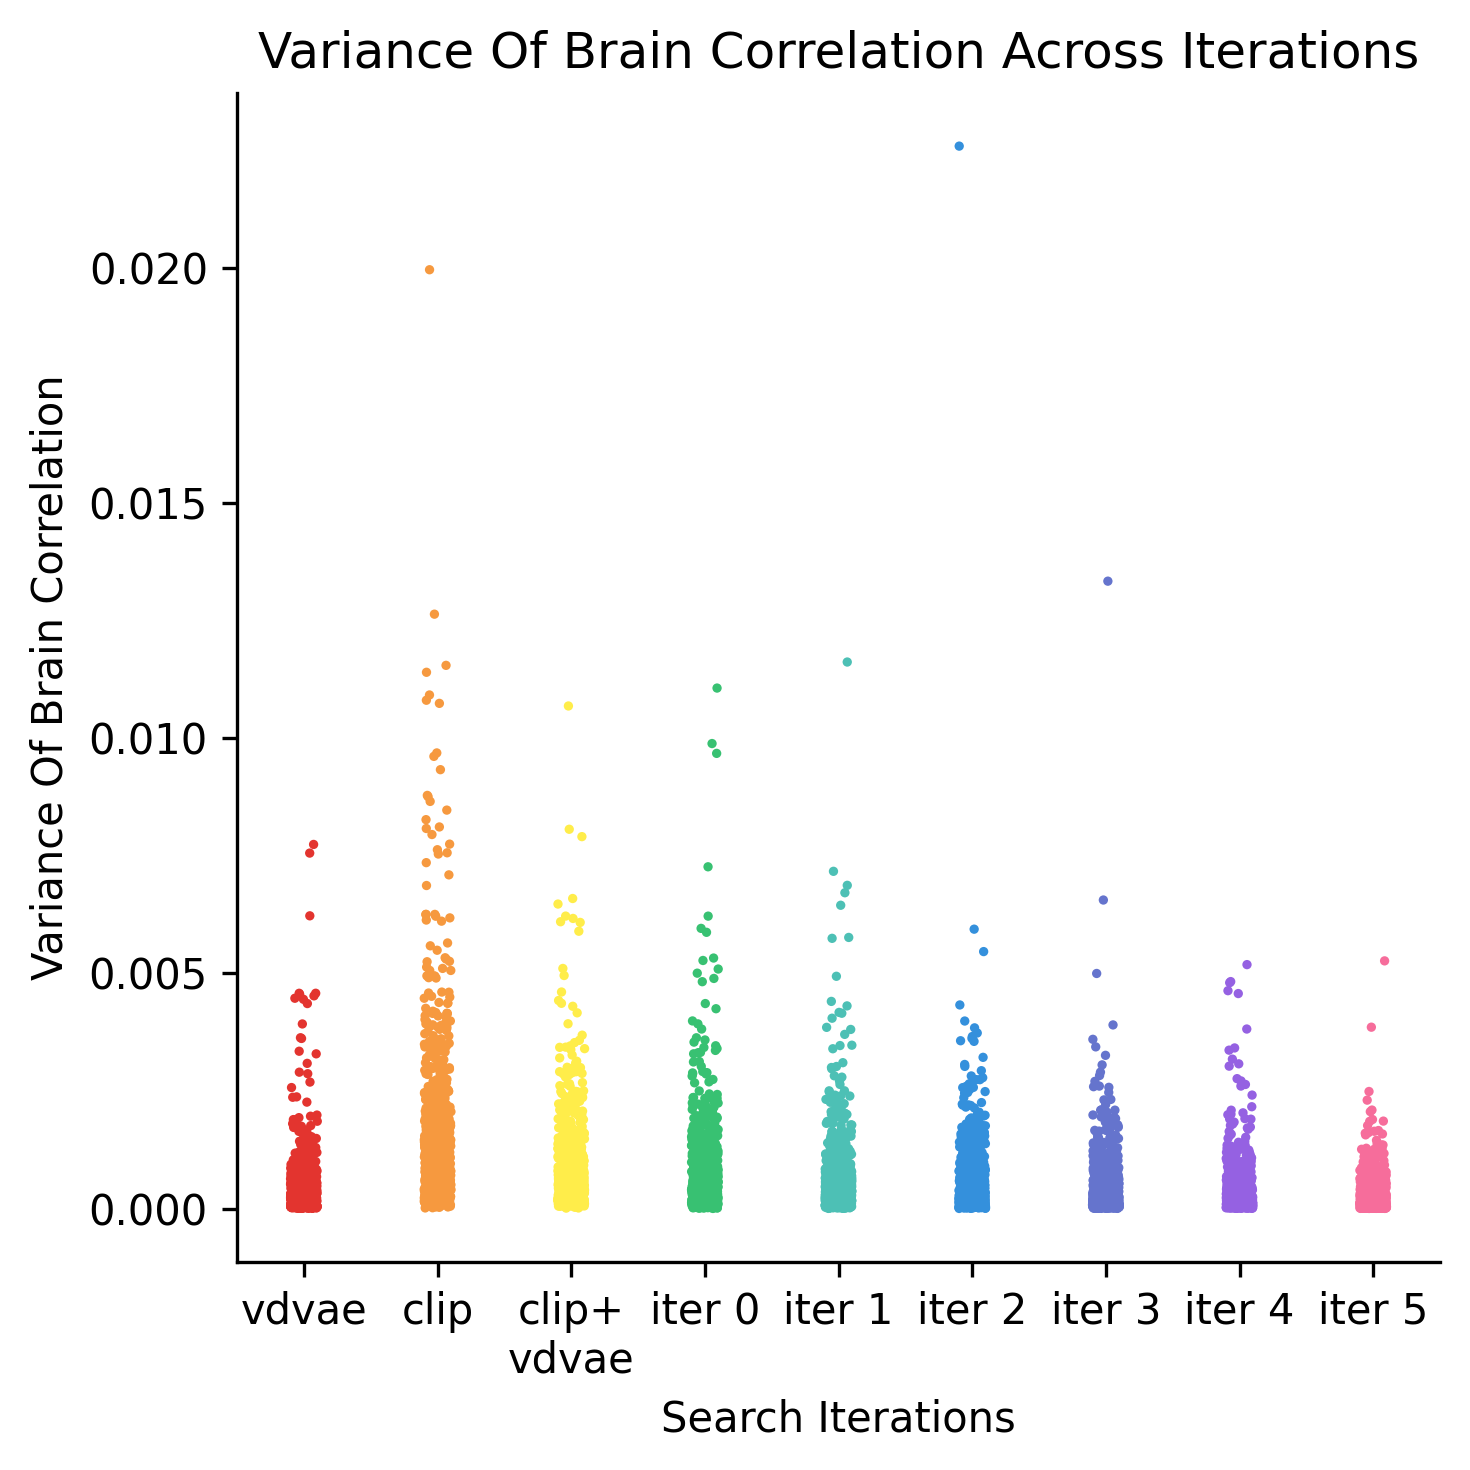

In [85]:
# print(df_data.tail())
custom_palette = ["#e3342f", "#f6993f", "#ffed4a", "#38c172", "#4dc0b5", "#3490dc", "#6574cd", "#9561e2", "#f66d9b"]

sns.set_palette(custom_palette)
sns.catplot(data=df_data, x="Search Iterations", y="Variance Of Brain Correlation", hue="Search Iterations", s=5).set(title='Variance Of Brain Correlation Across Iterations')